# Charts Deforestation

## 0. Reading data

In [1]:
from runner import io
import altair as alt
pantanal_deforestation_df = io.load_table("domain", "deforestation")
pantanal_df = io.load_table("domain", "pantanal_plot")
df_land_use = io.load_table("raw", "land_use")

In [2]:
pantanal_deforestation_df.head()

,city,location_UF,location,year,from_class,to_class,deforestation_ha
0,Aquidauana,MS,Aquidauana (MS),1985-01-01,304,1134,14445.862874
1,Aquidauana,MS,Aquidauana (MS),1986-01-01,304,1134,14026.138228
2,Aquidauana,MS,Aquidauana (MS),1987-01-01,304,1134,15730.481323
3,Aquidauana,MS,Aquidauana (MS),1988-01-01,304,1134,9578.366320
4,Aquidauana,MS,Aquidauana (MS),1989-01-01,304,1134,19906.438819


In [3]:
pantanal_df

,location,year,crop,area_ha,type,quantidade_ton,numero_cabecas
5105,Aquidauana (MS),1985,Rice,NaN,temporario,1575.0,NaN
5111,Bodoquena (MS),1985,Rice,NaN,temporario,2000.0,NaN
5122,Corumbá (MS),1985,Rice,NaN,temporario,0.0,NaN
5124,Coxim (MS),1985,Rice,NaN,temporario,9924.0,NaN
5144,Ladário (MS),1985,Rice,NaN,temporario,0.0,NaN
...,...,...,...,...,...,...,...
194579,Itiquira (MT),2020,Cattle,NaN,pecuaria,NaN,336622.0
194587,Lambari D'Oeste (MT),2020,Cattle,NaN,pecuaria,NaN,161266.0
194596,Nossa Senhora do Livramento (MT),2020,Cattle,NaN,pecuaria,NaN,185903.0
194616,Poconé (MT),2020,Cattle,NaN,pecuaria,NaN,531977.0


## 1. Config Altair

In [4]:
# Databricks notebook source
# MAGIC %md # Altair setup

# COMMAND ----------

# MAGIC %sh
# MAGIC # Installing altair
# MAGIC /databricks/python/bin/pip install altair altair_saver selenium -q
# MAGIC 
# MAGIC # Installing chromewebdriver for saving altair plots
# MAGIC apt-get update -y
# MAGIC apt-get install -y chromium-browser chromium-chromedriver

# COMMAND ----------

from datetime import datetime, timedelta
import json

import pandas as pd
import numpy as np

import altair as alt
alt.data_transformers.disable_max_rows()
alt.renderers.set_embed_options(scaleFactor=5)

# COMMAND ----------

# Altair theme setup
def tfg_palette(key="tfg_dark_light"):
    color_schemes = {
        'category-6': ['#ec8431', '#829eb1', '#c89d29', '#3580b1', '#adc839', '#ab7fb4'],
        'fire-7': ['#fbf2c7', '#f9e39c', '#f8d36e', '#f4bb6a', '#e68a4f', '#d15a40', '#ab4232'],
        'fireandice-6': ['#e68a4f', '#f4bb6a', '#f9e39c', '#dadfe2', '#a6b7c6', '#849eae'],
        'ice-7': ['#edefee', '#dadfe2', '#c4ccd2', '#a6b7c6', '#849eae', '#607785', '#47525d'],
        "tfg_dark": ['#0C66B5', '#BA1D32', '#0F8E40', '#E56F20', '#862BAF', '#626D69', '#ED5087'],
        "tfg_light": ['#3DB9E2', '#51DB63', '#E26868', '#FFB270', '#B37CEA', '#A8A1A4', '#FF87CD'],
    }
    
    color_schemes["tfg_dark_light"] = color_schemes["tfg_dark"] + color_schemes["tfg_light"]
    
    return color_schemes[key]

def science_theme_title(
    font="Helvetica Neue",
    titleFontSize=18,
    subtitleFontSize=14,
    titleFontWeight="normal",
    text=None,
    subtitle=None,
    **kwargs
):
    title_dict = {
        "align": "left",
        "anchor": "start",
        "frame": "group",
        "font": font,
        "fontSize": titleFontSize,
        "dy": -2,
        # Doesn't work directly in config
        "subtitleFont": font,
        "subtitleFontSize": subtitleFontSize,
        "fontWeight": titleFontWeight,
    }
    
    if text is not None:
        title_dict["text"] = text

    if subtitle is not None:
        title_dict["subtitle"] = subtitle
    
    if kwargs:
        title_dict.update(kwargs)

    return title_dict

def science_theme(
    width=1600/3,
    height=900/3,
    font="Helvetica Neue",
    titleFontSize=18,
    titleFontWeight="bold",
    subtitleFontSize=14,
    baseFontSize=14,
):    

    return {
        "config": {
            "view": {
                "width": width,
                "height": height,
                "fill": "white",
            },
            "title": science_theme_title(
                font=font,
                titleFontSize=titleFontSize,
                subtitleFontSize=subtitleFontSize,
            ),
            "axis": {
                "domainColor": "lightGrey",
                "gridColor": "lightGrey",
                "gridWidth": 0.25,
#                 "title": None,
                "titleFont": font,
                "titleFontSize": baseFontSize - 3,
                "labelFont": font,
                "labelFontSize": baseFontSize,
            },
            "legend": {
                "layout": {"anchor": "start"},
                "labelLimit": 0,
                "titleFontSize": baseFontSize,
                "titleFont": font,
                "labelFontSize": baseFontSize,
                "labelFont": font,
            },
            "header": {
                "title": None,
                "titleFont": font,
                "labelFont": font,
                "labelFontSize": baseFontSize,
                "labelPadding": 2,
            },
            "range": {
                "category": tfg_palette(),
            },
        }
    }

def science_theme_caption(text):
    return (
        alt.Chart(pd.DataFrame(),
                  title={"text": text, **science_theme_title(titleFontSize=12, titleFontWeight="normal")})
        .mark_text()
        .properties(height=1, view={"stroke": None})
    )

def science_theme_facet_title_background(width, fill="lightGrey", opacity=0.25, widthExtra=1):
    return (
        alt.Chart(pd.DataFrame({"a": [0]}))
        .mark_rect(fill=fill, opacity=opacity)
        .encode(y=alt.value(-25), y2=alt.value(-1), x=alt.value(0), x2=alt.value(width + widthExtra))
    )

def science_theme_facet_plot(chart, 
                             title=None, subtitle=None, caption=None,
                             width=300, height=150,
                             facet_kwargs=None, facet_resolve_scales=None,
                             focus_chart=None, focus_chart_width=300, focus_chart_height=150,
                             focus_chart_title="All",
                             focus_chart_resolve_scales=None,
                             grey_facet_background=True,
                             configure_headerColumn=True,
                             **kwargs):
    
    if facet_kwargs is not None:
        if grey_facet_background:
          chart = (chart + science_theme_facet_title_background(width=width))
        chart = chart.facet(**facet_kwargs)

        if facet_resolve_scales is not None:
          chart = chart.resolve_scale(**facet_resolve_scales)
        
        if focus_chart is not None:
            if grey_facet_background: 
              focus_chart = focus_chart + science_theme_facet_title_background(width=focus_chart_width)
            focus_chart = focus_chart.properties(
                width=focus_chart_width, 
                height=focus_chart_height,
                title=science_theme_title(text=focus_chart_title, titleFontSize=14, anchor="middle", offset=-22 if grey_facet_background else 0)
            )
            chart = focus_chart | chart
            
            if focus_chart_resolve_scales is not None:
              chart = chart.resolve_scale(**focus_chart_resolve_scales)
    
    chart = (
        (chart
         # Adding caption
         & science_theme_caption(caption)).resolve_scale(
            x="independent", y="independent", size="independent",
            color="independent", fill="independent", stroke="independent", opacity="independent",
        )
        # Adding title and subtitle
        .properties(title=science_theme_title(text=title, subtitle=subtitle))
        # Configuring plot size
        .configure_view(width=width, height=height)
    )
    
    if (facet_kwargs is not None) and grey_facet_background and configure_headerColumn:
        chart = chart.configure_headerColumn(labelPadding=-20).configure_headerFacet(labelPadding=-20)
    
    return chart
  
def science_theme_weekly_highlights(format="%b %d", tickCount=40): 
    return alt.Axis(
        format=format,
        tickCount=tickCount,
        gridOpacity=alt.condition(
            alt.Predicate(alt.FieldEqualPredicate(field='value', timeUnit="day", equal=1)),
            alt.value(1.0),
            alt.value(0.4)
        ),
    )
    
alt.themes.register("science_theme", science_theme)
alt.themes.enable("science_theme")

# COMMAND ----------

# DBTITLE 1,Test the saver works with a sample graph save
# import altair_saver
# import pandas as pd

# test_path = '/dbfs/mnt/tfg-ua/airflow/creatives/altair_test_save.png'

# source = pd.DataFrame({'x': ['A'], 'y': [1]})
# chart = alt.Chart(source).mark_bar().encode(x='x', y='y')
# try:
#   chart.save(test_path)
# except ValueError as e:
#   if 'No enabled saver found' in str(e):
#     # retry with an explicit method + driver to provide a more informative error message
#     altair_saver.save(chart, test_path, method='selenium', webdriver='chrome')
#   raise e  # in case the more explicit method works for some reason, or this is an unrecognized error



ThemeRegistry.enable('science_theme')

## 2. Deforestation Analysis

### 2.1 Evolution Deforestation

In [5]:
pantanal_deforestation_df

,city,location_UF,location,year,from_class,to_class,deforestation_ha
0,Aquidauana,MS,Aquidauana (MS),1985-01-01,304,1134,14445.862874
1,Aquidauana,MS,Aquidauana (MS),1986-01-01,304,1134,14026.138228
2,Aquidauana,MS,Aquidauana (MS),1987-01-01,304,1134,15730.481323
3,Aquidauana,MS,Aquidauana (MS),1988-01-01,304,1134,9578.366320
4,Aquidauana,MS,Aquidauana (MS),1989-01-01,304,1134,19906.438819
...,...,...,...,...,...,...,...
571,Sonora,MS,Sonora (MS),2016-01-01,264,999,1864.663098
572,Sonora,MS,Sonora (MS),2017-01-01,264,999,1765.371164
573,Sonora,MS,Sonora (MS),2018-01-01,264,999,1760.021683
574,Sonora,MS,Sonora (MS),2019-01-01,264,999,2371.518044


In [6]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.55).encode(
    x=alt.X('year:T', axis=alt.Axis(title="Year")),
    y=alt.Y('deforestation_ha:Q', axis=alt.Axis(title="Deforestation (ha)")),
    color='location',
#     opacity='location_UF:O'
)

# qntd_total_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_point(color='red').encode(
#     x='year:T',
#     y='sum_deforestation:Q',
# #     color='location',
# #     opacity='location_UF:O'
# ).transform_aggregate(
#     sum_deforestation='sum(deforestation_ha)',
#     groupby=[
#         "year", 
#     ]
# )

final_chart = qntd_deforestation_chart.properties(
    width=700,
    height=500
).properties(
    title=science_theme_title(
        text="Evolution of deforestation by municipality in Pantanal", 
        subtitle="1985-2020"
    )
)

final_chart

alt.Chart(...)

In [7]:
# qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
#     x='year:T',
#     y=alt.Y('deforestation_ha:Q', stack='normalize'),
#     color='location',
# #     opacity='location_UF:O'
# )

# (qntd_deforestation_chart).properties(
#     width=800,
#     height=550
# )

In [8]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
    x='year:T',
    y='sum_deforestation:Q',
    color='location_UF',
#     opacity='location_UF:O'
).transform_aggregate(
    sum_deforestation='sum(deforestation_ha)',
    groupby=[
        "year", 
#         "location",
        "location_UF"
    ]
)

(qntd_deforestation_chart).properties(
    width=800,
    height=550
)

alt.Chart(...)

In [9]:
qntd_deforestation_chart = alt.Chart(pantanal_deforestation_df).mark_area(opacity=0.7).encode(
    x='year:T',
    y=alt.Y('sum_deforestation:Q', stack='normalize'),
    color='location_UF',
#     opacity='location_UF:O'
).transform_aggregate(
    sum_deforestation='sum(deforestation_ha)',
    groupby=[
        "year", 
#         "location",
        "location_UF"
    ]
)

(qntd_deforestation_chart).properties(
    width=800,
    height=550
)

alt.Chart(...)

### 2.2 Charts correlation deforestation & production

In [10]:
pantanal_df.groupby(['crop']).sum().reset_index().sort_values('quantidade_ton', ascending=False)

,crop,area_ha,quantidade_ton,numero_cabecas
9,Sugar cane,868635.0,60470257.0,0.0
8,Soybeans (grain),7961848.0,23729442.0,0.0
4,Corn (grain),2556605.0,11400323.0,0.0
1,Cassava,170400.0,2777944.0,0.0
7,Rice,575352.0,1781528.0,0.0
5,Herbaceous cotton (seed),477760.0,1552551.0,0.0
6,Orange,7542.0,481847.0,0.0
0,Beans (grain),182129.0,132371.0,0.0
3,Coffee (beans) Total,3868.0,6470.0,0.0
10,Wheat (grain),1335.0,2428.0,0.0


In [11]:
pantanal_df['year'] = pd.to_datetime(pantanal_df['year'])

In [12]:
complete_df = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    pantanal_df,
    on=['location', 'year'],
    how='left'
)

In [13]:
main_cultures = ['Sugar cane', 'Soybeans (grain)', 'Corn (grain)']
main_cultures_complete_df = complete_df[complete_df.crop.isin(main_cultures)]

In [14]:
main_cultures_complete_df.corr()

,deforestation_ha,area_ha,quantidade_ton,numero_cabecas
deforestation_ha,1.000000,-0.070293,-0.133905,NaN
area_ha,-0.070293,1.000000,0.458390,NaN
quantidade_ton,-0.133905,0.458390,1.000000,NaN
numero_cabecas,NaN,NaN,NaN,NaN


In [15]:
main_cultures_complete_df.rename(
    columns={
        'area_ha': 'Production Area (ha)',
        'deforestation_ha': 'Deforestation Area (ha)',
        'quantidade_ton': 'Production volume (ton)'
    },
    inplace=True
)

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_53305/181077010.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_cultures_complete_df.rename(


In [16]:
main_cultures_complete_df["location_UF"] = main_cultures_complete_df["location"].str[-3:-1]

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_53305/967949548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_cultures_complete_df["location_UF"] = main_cultures_complete_df["location"].str[-3:-1]


In [17]:
corr_chart = alt.Chart(main_cultures_complete_df).mark_point(size=17).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='crop:N',
    opacity='location_UF:N'
).properties(
    width=150,
    height=150
).repeat(
    row=['Production Area (ha)', 'Deforestation Area (ha)', 'Production volume (ton)'],
    column=['Production volume (ton)', 'Deforestation Area (ha)', 'Production Area (ha)']
)


final_chart = corr_chart.properties(
    title=science_theme_title(
        text="Pair plot between Production Area, Production Quantity and Deforestation", 
        subtitle="1985-2020"
    )
).configure_range(
    category={'scheme': 'dark2'}
)

final_chart

alt.RepeatChart(...)

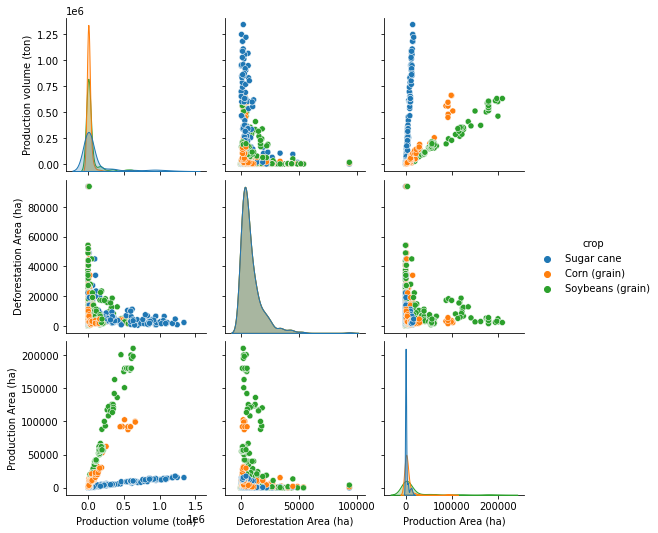

In [18]:
import seaborn as sns 
sns.pairplot(main_cultures_complete_df[['Production volume (ton)', 'Deforestation Area (ha)', 'Production Area (ha)', 'crop']], hue='crop')

In [19]:
pantanal_df_pecuaria = pantanal_df.query('type == "pecuaria"')
pantanal_df_pecuaria['year'] = pd.to_datetime(pantanal_df_pecuaria['year'])
complete_df_pecuaria = pantanal_deforestation_df[['location', 'year', 'deforestation_ha']].merge(
    pantanal_df_pecuaria,
    on=['location', 'year'],
    how='left'
)
complete_df_pecuaria['numero_cabecas'] = complete_df_pecuaria['numero_cabecas'].astype('float')

/var/folders/15/swv8hztj3m331bbjtnrdtvfw0000gn/T/ipykernel_53305/1373358172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pantanal_df_pecuaria['year'] = pd.to_datetime(pantanal_df_pecuaria['year'])


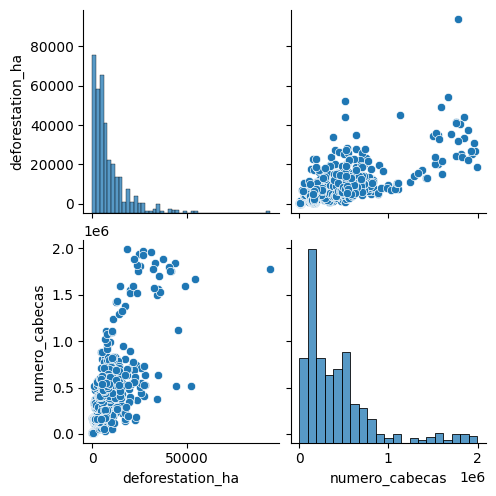

In [20]:
sns.pairplot(complete_df_pecuaria[['deforestation_ha', 'numero_cabecas']])

In [33]:
chart = alt.Chart(complete_df_pecuaria).mark_point(color='green').encode(
    x=alt.X('numero_cabecas', axis=alt.Axis(title='Number of livestock heads')),
    y=alt.Y('deforestation_ha', axis=alt.Axis(title='Deforestation (ha)')),
)

# reg_chart = (
#     chart + 
#     chart.transform_regression(
#         'numero_cabecas', 'deforestation_ha'
#     ).mark_line(
#         color='red', strokeDash=[2]
#     )
# )

# text = alt.Chart({'values':[{}]}).mark_text(
#     align="left", baseline="top", size=15, color='red', angle=350
# ).encode(
#     x=alt.value(400),  # pixels from left
#     y=alt.value(370),  # pixels from top
#     text=alt.value("y = 2337.35 + 0.0039 * x"))

text2 = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top", size=15, color='red',
).encode(
    x=alt.value(20),  # pixels from left
    y=alt.value(20),  # pixels from top
    text=alt.value(" r = 69.48%"))

reg_chart = chart + text2

final_chart = reg_chart.properties(
    width=750,
    height=500,
    title=science_theme_title(
        text="Linear regression of Deforestation X Number of livestock heads", 
        subtitle="1985-2020"
    )
)

final_chart

alt.LayerChart(...)

In [22]:
df_train = complete_df_pecuaria[['numero_cabecas', 'deforestation_ha']].dropna()
df_train.corr()

,numero_cabecas,deforestation_ha
numero_cabecas,1.00000,0.69484
deforestation_ha,0.69484,1.00000


### 2.3 Quick modelling

#### 2.3.1 Config sklearn 

In [23]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplotlib
from scipy.stats import loguniform


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score,roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

#### 2.3.2 Modelling 

In [24]:
linear_model = LinearRegression()
linear_model.fit(df_train.drop(columns=['deforestation_ha']), df_train['deforestation_ha'])
linear_model.__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'feature_names_in_': array(['numero_cabecas'], dtype=object),
 'n_features_in_': 1,
 'coef_': array([0.01637104]),
 'rank_': 1,
 'singular_': array([9461282.1287026]),
 'intercept_': 1603.041486286701}

In [25]:
from sklearn.metrics import r2_score
r2_score(
    df_train['deforestation_ha'],
    linear_model.predict(df_train.drop(columns=['deforestation_ha'])), 
)

0.4828022244499647

In [26]:
cat_vars_complete = [i for i in df_train.columns if df_train.dtypes[i] == 'object']
num_vars_complete = [i for i in df_train.columns if df_train.dtypes[i] == 'float64' or df_train.dtypes[i] == 'int64']

ignore_variables = []
cat_vars = [element for element in cat_vars_complete if (element not in ignore_variables)]
specific_vars = []
num_vars = [element for element in num_vars_complete if (element != 'deforestation_ha' and element not in specific_vars + ignore_variables)]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
#     ('polynomial_features',PolynomialFeatures(interaction_only=True)),
#     ('pca', PCA())
])

specific_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('power_transform', PowerTransformer(method='yeo-johnson')),
#     ('polynomial_features',PolynomialFeatures(interaction_only=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
#     ('truncated_svd', TruncatedSVD())
#     ('sparse_pca', sparse_pca),
#     ('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)
    ])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_vars),
#         ('specific', specific_transformer, specific_vars),
#         ('cat', categorical_transformer, cat_vars),
    ])

linear_model = LinearRegression()

# param_dist = dict()
# param_dist['solver'] = ['newton-cg', 'liblinear']
# param_dist['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# param_dist['C'] = loguniform(1e-5, 100)

# lg_random_search = RandomizedSearchCV(lg_model, param_distributions=param_dist)



model_lr = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', linear_model)
    ]
)

model_lr.fit(
    df_train.drop(columns=['deforestation_ha']), 
    df_train['deforestation_ha']
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['numero_cabecas'])])),
                ('model', LinearRegression())])

In [27]:
model_lr['model'].__dict__

{'fit_intercept': True,
 'normalize': 'deprecated',
 'copy_X': True,
 'n_jobs': None,
 'positive': False,
 'n_features_in_': 1,
 'coef_': array([6604.57682874]),
 'rank_': 1,
 'singular_': array([23.4520788]),
 'intercept_': 8605.742612567212}

In [28]:
from sklearn.metrics import r2_score
r2_score(
    df_train['deforestation_ha'],
    model_lr.predict(df_train.drop(columns=['deforestation_ha'])), 
)

0.4828022244499647

### 2.3 Deforestation boxplots

In [29]:
deforestation_boxplot = alt.Chart(pantanal_deforestation_df.rename(
    columns={'deforestation_ha': 'Deforestation (ha)'}
)).mark_boxplot(size=40, extent=0.5, opacity=0.7).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('Deforestation (ha):Q',scale=alt.Scale(zero=False)),
    color=alt.Color('location', legend=None)
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart = deforestation_boxplot.properties(
    width=850,
    height=400,
    title=science_theme_title(
        text="Distribution of Deforestation during the years for each Municipality", 
        subtitle="1985-2020"
    )
)

final_chart

alt.Chart(...)

In [54]:
relative_deforestation_df = io.load_table("domain", "area_pantanal_features")
relative_deforestation_df["year"] = pd.to_datetime(relative_deforestation_df["year"], format="%Y")
relative_deforestation_df.head()

,location,year,total_area_ha,natural_area_ha
0,Aquidauana (MS),1985-01-01,1.708776e+06,1.509057e+06
1,Aquidauana (MS),1986-01-01,1.708776e+06,1.491534e+06
2,Aquidauana (MS),1987-01-01,1.708776e+06,1.477761e+06
3,Aquidauana (MS),1988-01-01,1.708776e+06,1.462886e+06
4,Aquidauana (MS),1989-01-01,1.708776e+06,1.452978e+06


In [55]:
relative_deforestation_df = relative_deforestation_df.merge(
    pantanal_deforestation_df[["location", "year", "deforestation_ha"]],
    on=['location', 'year'],
    how='inner',
)

relative_deforestation_df["relative_deforestation"] = relative_deforestation_df["deforestation_ha"] / relative_deforestation_df["total_area_ha"]
relative_deforestation_df.head()

,location,year,total_area_ha,natural_area_ha,deforestation_ha,relative_deforestation
0,Aquidauana (MS),1985-01-01,1.708776e+06,1.509057e+06,14445.862874,0.008454
1,Aquidauana (MS),1986-01-01,1.708776e+06,1.491534e+06,14026.138228,0.008208
2,Aquidauana (MS),1987-01-01,1.708776e+06,1.477761e+06,15730.481323,0.009206
3,Aquidauana (MS),1988-01-01,1.708776e+06,1.462886e+06,9578.366320,0.005605
4,Aquidauana (MS),1989-01-01,1.708776e+06,1.452978e+06,19906.438819,0.011650


In [61]:
relative_deforestation_df['total_deforested_percentage'] = (
    (relative_deforestation_df['total_area_ha'] - relative_deforestation_df['natural_area_ha'])
    /relative_deforestation_df['total_area_ha']
)

relative_deforestation_df.head()

relative_deforestation_df['max_deforested_percentage'] = (
    relative_deforestation_df.groupby(['location'])['total_deforested_percentage'].transform('max')
)

In [64]:
deforestation_boxplot = alt.Chart(relative_deforestation_df.rename(
    columns={'relative_deforestation': 'Relative Deforestation (%)'}
)).mark_boxplot(size=40, extent=0.5, opacity=0.7).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('Relative Deforestation (%):Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('location', legend=None)
)

deforestation_percentage_chart = alt.Chart(
    relative_deforestation_df
).mark_rule(color='black', opacity=0.8, strokeDash=[2]).encode(
    x=alt.X('location:O', axis=alt.Axis(title="Municipality")),
    y=alt.Y('max_deforested_percentage:Q',scale=alt.Scale(zero=False), 
            axis=alt.Axis(format='%', title="Deforested area (%)")
           ),
)


final_chart = (alt.layer(deforestation_percentage_chart, deforestation_boxplot).resolve_scale(y='independent')).properties(
    width=850,
    height=400,
    title=science_theme_title(
        text="Relative Deforestation Distribution (Boxplot) and Mean deforested area (Dashed Line)", 
        subtitle="1985-2020"
    )
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
)

final_chart

alt.LayerChart(...)

## 3. Fire Analysis

In [ ]:
queimadas_df = io.load_table("domain", "queimadas")
queimadas_df.head()

,location,year,queimadas_ha
0,Aquidauana (MS),1985,125138.792731
1,Aquidauana (MS),1986,80538.528249
2,Aquidauana (MS),1987,22817.472595
3,Aquidauana (MS),1988,203737.325198
4,Aquidauana (MS),1989,18833.167266


In [ ]:
queimadas_df.query('year != "2021"').query("location.str.contains('Corumb')").tail(5)

,location,year,queimadas_ha
142,Corumbá (MS),2016,590796.225406
143,Corumbá (MS),2017,338472.339991
144,Corumbá (MS),2018,75867.648632
145,Corumbá (MS),2019,746828.863977
146,Corumbá (MS),2020,949695.786537


In [ ]:
qntd_deforestation_chart = alt.Chart(queimadas_df.query('year != "2021"')).mark_area(opacity=0.55).encode(
    x=alt.X('year:T', axis=alt.Axis(title="Year")),
    y=alt.Y('queimadas_ha:Q', axis=alt.Axis(title="Natural Area Burned (ha)")),
    color='location',
)

final_chart = qntd_deforestation_chart.properties(
    width=700,
    height=500
).properties(
    title=science_theme_title(
        text="Evolution of Natural Area Burned by municipality in Pantanal", 
        subtitle="1985-2020"
    )
)

final_chart

alt.Chart(...)

In [ ]:
queimadas_raw_df = io.load_table("raw", "queimadas")

In [ ]:
queimadas_raw_df.query("city == 'CORUMBÁ' and level_0 == 'Natural'").sum()

state         MATO GROSSO DO SULMATO GROSSO DO SULMATO GROSS...
city                        CORUMBÁCORUMBÁCORUMBÁCORUMBÁCORUMBÁ
feature_id                                                 6015
index                                                     11700
class_id                                                     63
level_0                     NaturalNaturalNaturalNaturalNatural
level_1       1. Forest1. Forest2. Non Forest Natural Format...
level_2       Forest FormationSavanna FormationWetlandGrassl...
level_3       Forest FormationSavanna FormationWetlandGrassl...
level_4       Forest FormationSavanna FormationWetlandGrassl...
color                       #006400#00ff00#45c2a5#b8af4f#0000ff
1985                                              244127.713992
1986                                              749603.050039
1987                                              180307.622062
1988                                              281069.351338
1989                                    

In [80]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [81]:
!ls

MANIFEST.in      config           notebooks        runner
Makefile         config.local.env pyproject.toml   runner.egg-info
README.md        data             requirements     setup.py
activate         jupyter          run              utils


/
    .DS_Store
    Makefile
    pyproject.toml
    config.local.env
    MANIFEST.in
    README.md
    setup.py
    .gitignore
    activate
    run
    jupyter
config/
    10-data.yaml
    10-logging.yaml
    00-meta.yaml
runner/
    logging.py
    io.py
    __init__.py
    fs.py
    data_prep/
        __init__.py
        run_data_prep.py
        data_utils/
            __init__.py
            utils.py
            __pycache__/
                __init__.cpython-39.pyc
                utils.cpython-39.pyc
        __pycache__/
            __init__.cpython-39.pyc
            run_data_prep.cpython-39.pyc
        raw_prep/
            queimadas.py
            quantidade.py
            pecuaria.py
            environmental_laws.py
            __init__.py
            run_raw_prep.py
            land_use_transitions.py
            land_use_transitions_old.py
            area.py
            land_use.py
            __pycache__/
                __init__.cpython-39.pyc
                area.cpython-3